# Variational inference using the finite approximation

In [98]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from copy import deepcopy

import VI_algorithms_lib
import valez_finite_VI_lib


# Draw data

In [99]:
# np.random.seed(34134) # cavi works great for this seed
# np.random.seed(31431)
np.random.seed(234213)

Num_samples = 500 # sample size
D = 2 # dimension
# so X will be a N\times D matrix

K_inf = 3 # take to be large for a good approximation to the IBP

alpha = 10 # IBP parameter

# Parameters to draw A from MVN
sigma_eps = .1 # variance of noise
sigma_A = 100

# generate data
Pi, Z, mu, A, X = valez_finite_VI_lib.generate_data(Num_samples, D, K_inf, sigma_A, sigma_eps, alpha)

K_approx = deepcopy(K_inf) # variational truncation


# Run CAVI with random restarts

In [100]:
VI_instance = VI_algorithms_lib.VI_algorithms(X, K_approx, alpha, sigma_eps, sigma_A)

n_restart = 20
elbo_end = np.array([])

for i in range(n_restart): 
    VI_instance.re_init() # re initialize
    [tau_tmp, nu_tmp, phi_mu_tmp, phi_var_tmp, elbo] \
        = VI_instance.run_cavi(max_iter=200, tol=1e-6, verbose = False) # run cavi
        
    elbo_end = np.append(elbo_end, elbo[-1])
    
    # see if posterior predictive is better than all previous ones
    if (i == 0) or np.all(elbo_end[i] > elbo_end[:i]): 
        tau = deepcopy(tau_tmp)
        nu = deepcopy(nu_tmp)
        phi_mu = deepcopy(phi_mu_tmp)
        phi_var = deepcopy(phi_var_tmp)
        # print(i)
    print(i)
    
#print(elbo_end)
#print(np.argmax(elbo_end))

0
2
5
elbo decreased!  Difference:  -1.16415321827e-10
elbo decreased!  Difference:  -1.16415321827e-10
elbo decreased!  Difference:  -1.16415321827e-10
16
[  1.02566154e+06   1.02486122e+06   1.02566792e+06   9.29961512e+05
   1.02564467e+06   1.02715404e+06   8.75683855e+05   8.75683855e+05
   1.01929935e+06   1.02465552e+06   8.75683855e+05   1.02486122e+06
  -3.97947974e+01   9.56529347e+05   9.48653408e+05   1.02568854e+06
   1.02715404e+06   9.59089668e+05   1.02613952e+06   1.02613952e+06]
16


Z (unpermuted): 
 [[1 1 1]
 [1 1 1]
 [1 1 0]
 [0 1 0]
 [1 1 1]
 [0 1 1]
 [0 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]]
** procedure did not give a true permutation
permutation:  [0, 1, 2]
Z (permuted) 
 [[1 1 1]
 [1 1 1]
 [1 1 0]
 [0 1 0]
 [1 1 1]
 [0 1 1]
 [0 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]]
round_nu 
 [[ 1.          0.          1.        ]
 [ 1.          0.          1.        ]
 [ 1.          1.          1.        ]
 [ 0.          0.72437951  1.        ]
 [ 1.          0.          1.        ]
 [ 0.          0.          1.        ]
 [ 0.          0.          1.        ]
 [ 1.          0.          1.        ]
 [ 1.          0.          1.        ]
 [ 1.          0.          1.        ]]
l1 error (after permutation):  [0.0, 0.70165397781007344, 0.28199999999999997]


true A (permuted): 
 [[ -4.56292503 -16.4070799 ]
 [ 14.39945263  -2.48764823]
 [  2.67705195   0.75207494]]
phi_mu: 
 [[ -3.10182363 -16.02510257]
 [ -2.66895405  -0.74183088]
 [ 15.80496317  -2.06646181]]


true Pi (permuted):  [ 0

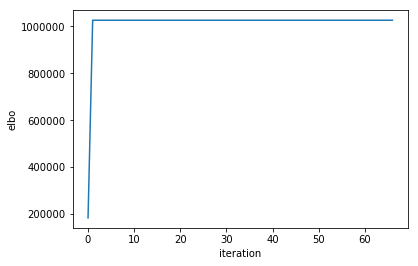

In [101]:
Pi_computed = tau[:,0]/(tau[:,0] + tau[:,1])
round_nu = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)
print('Z (unpermuted): \n', Z[0:10])

# Find the minimizing permutation.
accuracy_mat = [[ np.sum(np.abs(Z[:, i] - nu[:, j]))/Num_samples for i in range(K_inf) ]
                  for j in range(K_inf) ]
perm_tmp = np.argmin(accuracy_mat, 1)

# check that we have a true permuation
if len(perm_tmp) == len(set(perm_tmp)):  
    perm = perm_tmp
else: 
    print('** procedure did not give a true permutation')
    perm = [0,1,2]

print('permutation: ', perm)
    
# print Z (permuted) and nu
print('Z (permuted) \n', Z[0:10, perm])
print('round_nu \n', round_nu[0:10,:])

print('l1 error (after permutation): ', \
    [ np.sum(np.abs(Z[:, perm[i]] - nu[:, i]))/Num_samples for i in range(K_inf) ])

print('\n')
print('true A (permuted): \n', A[perm, :])
print('phi_mu: \n', phi_mu.transpose())

print('\n')
print('true Pi (permuted): ', Pi)
print('computed Pi: ', Pi_computed)
plt.clf()
plt.plot(elbo)
plt.xlabel('iteration')
plt.ylabel('elbo')
plt.show()

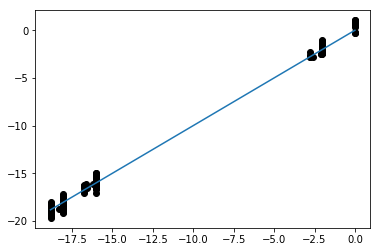

In [103]:
pred_x = np.dot(nu, phi_mu.transpose())
col = 1
plt.clf()
plt.plot(pred_x[:, col], X[:, col], 'ko')

diag = np.linspace(np.min(pred_x[:,col]),np.max(pred_x[:,col]))
plt.plot(diag,diag)

plt.show()